## Classifying and Natural Language Processing with Yelp Reviews Data
#### W207 Section 3, Group - <span style="color:orange"><strong>C</strong></span>olors
#### Summer, 2018
#### Team members:
- Chandra Sekar, chandra-sekar@ischool.berkeley.edu
- Guangyu (Gary) Pei, guangyu.pei@ischool.berkeley.edu
- Jooyeon (Irene) Seo, jooyeon@ischool.berkeley.edu
- Sijie (Anne) Yu, syu.anne@berkeley.edu

In [2]:
# General libraries.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import time
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

# SK-learn libraries for learning.
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# keras package for neural networks.
from keras import models
from keras import layers
from keras import optimizers

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# Config Jupyter session
%config IPCompleter.greedy=True

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Global configurations
np.set_printoptions(precision=4, suppress=True)

# Config system logs
import logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s %(levelname)s %(message)s')

# print versions
print("Python version used:", sys.version)
print("Numpy version used:", np.__version__)
print("sklearn version used:", sklearn.__version__)

Python version used: 3.6.5 (default, Apr  1 2018, 05:46:30) 
[GCC 7.3.0]
Numpy version used: 1.15.0
sklearn version used: 0.19.2


## Introduction

In this project, we utilize Yelp data (from kaggle) to achieve the following two objectives.

  (1) Predict reviewer's attitude (namely **positive** or **negative**) based on his/her review comments. In another words, we want to make prediction about a reviewer's attitude toward a business given his/her review.
  
  (2) Perform the quality analysis about a business using its user reviews. Namely, we want to find out what makes a business a good business from customers' perspective.

We use document-term matrix (DTM) generated from Yelp reviews as predicator variables. In order to avoid bias due to differences in business categories, we focus on review data that are related to similar business such as bars or restaurants only.

To achieve the first objective, we use reviewers' ratings as target variable and we use various supervised machine learning algorithms to predict reviewers' attitude toward the business. However, reviewers' ratings are generally not good labels to indicate the quality of business. The Yelp dataset itself is not sufficient to leverage supervised machine learning algorithms to predict business quality. To address this challenge, we perform sentiment analysis using reviewers' ratings to help us identifying/clustering business as good and bad business based on reviewers' attitude reflected in their reviews. To this end, we used the sentiment analysis tools to rate the quality of business and identify sentiment words accordingly.

In the following, we will first present the results on using supervised machine learning for predicting reviewer's attitude toward a business. We then present our results on business sentiment analysis.

## Supervised machine learning for predicting reviewer's attitude toward business

#### The Yelp Review Dataset
We have preprocessed original yelp review data to create our project dataset, which contain reviews about restaurants. But we also create another dataset which furthur narrow to "bars". We played with different sets of data so to find useful information to help us create better models:

[1. Restraurant_Yelp_Review](https://github.com/annesjyu/m207_summer_2018/blob/master/data_restaurants_reviews_30_to_200_stars_1_5)

[2. Bars_Yelp_Review](https://github.com/annesjyu/m207_summer_2018/blob/master/bars_data)

In [3]:
def load_data(fnm = "bars_data", seed = 1234,
              train_frac= 0.8, dev_size = 1000):
    data = pd.read_pickle(fnm)
    np.random.seed(seed)
    data = data.sample(frac=1).reset_index(drop=True)
    print ("Total data size:", data.shape[0])
    traing_size = int(np.floor(data.shape[0]*train_frac))
    test_size = int(np.floor(data.shape[0]*(1.0-train_frac))) - dev_size
    train_data, train_labels = data.X[0:traing_size], data.Y[0:traing_size]
    test_data, test_labels = data.X[traing_size:(traing_size+test_size)], data.Y[traing_size:(traing_size+test_size)]
    dev_data, dev_labels = data.X[(traing_size+test_size):-1], data.Y[(traing_size+test_size):-1]
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels
    

train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_data()

print ('train data size: ', train_data.shape)
print ('test data size: ', test_data.shape)
print ('dev data size: ', dev_data.shape)

Total data size: 30000
train data size:  (24000,)
test data size:  (4999,)
dev data size:  (1000,)


Analyze train, dev and test datasets to find out data distributions. Ideally we want to have 50% examples for either label.

In [4]:
print ('positive train data: ', len(np.where(train_labels==1)[0]), 
       ', negative train data: ', len(np.where(train_labels==0)[0]))
print ('positive test data: ', len(np.where(test_labels==1)[0]), 
       ', negative test data: ', len(np.where(test_labels==0)[0]))
print ('positive dev data: ', len(np.where(dev_labels==1)[0]), 
       ', negative dev data: ', len(np.where(dev_labels==0)[0]))

positive train data:  11998 , negative train data:  12002
positive test data:  2514 , negative test data:  2485
positive dev data:  488 , negative dev data:  512


#### Natural Language Pre-processing on Review Texts

We will create a doc-term matrix from review texts, so that classifiers can use it as an feature. There are a couple of steps of doing it. 
- First of all we will conduct Natural Language Processing with customized stemmer, stop words etc. 
- Secondly we will use Logistic Regression + L1 Regulization to reduce less-important terms.

In [5]:
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words

categories = ['Positive reviews', 'Negative reviews']

def NLP_text(remove_zero_weight_terms=True,
             Logistic_Regression_optimal_C=10,
             add_terms=None, 
             exclude_terms=None):
    """The function will take a vector of review texts and create a Doc-Term Matrix.
    
    Inputs:
        remove_zero_weight_terms: if true, will remove terms with zero weights.
        Logistic_Regression_optimal_C: used only if remove_zero_weight_terms == True:
            a L1 regulirizer will be used to exclude terms with zero weight.
        add_terms: after EDA, we find some words are stemmed, however their original forms
            could have important meanings, e.g. old, older, young, younger. We manually 
            put them back into dict. For example, set(['older']).
        exclude_terms: after EDA, we find some terms are too frequent in most data,
            for example, restraurant, so we exclude them from DTM.
            For example, set(['restraurant']).
            
    Outputs:
        a customized vectorizer object.
    """    
    def better_tokenizer(s):
        def simple_stemmer(s):
            def replace(word, pattern, rep):
                return re.sub(r'{}$'.format(pattern), r'{}'.format(rep), word, count=1, flags=re.IGNORECASE)
            patterns = {'led':'l', 'ked':'k', # stem verb
                        'rs':'r', 'ds':'d', 'es':'e', 'ts':'t', # stem noun
                        'ly':''} # stem adj
            for p, rep in patterns.items():
                if re.search(r'{}$'.format(p), s) is not None:
                    return replace(s, p, rep)
            return s

        # Get the original tokenizer
        tokens = TfidfVectorizer().build_tokenizer()(s)        
        # We compute the average length of original dictionary, which is 6.7
        # then ignore extremly short and long words, like more than 6.7/2 and 6.7*2.
        WORD_LEN = 6.7
        #return [p_stemmer.stem(t) for t in tokens if len(t) >= WORD_LEN/2 
        #        and len(t) <= WORD_LEN*2]
        return [simple_stemmer(t) for t in tokens if len(t) >= WORD_LEN/2 and len(t) <= WORD_LEN*2]
           
    shuffle = np.random.permutation(train_data.shape[0])
    X, Y = train_data[shuffle], train_labels[shuffle]
    TUNE_DATA_SIZE = int(len(train_data)/6)
    data = X[0:TUNE_DATA_SIZE]
    labels = Y[0:TUNE_DATA_SIZE]
    
    vect = TfidfVectorizer(strip_accents='ascii', ngram_range=(1,1), min_df=2, 
                           stop_words='english', use_idf=False, sublinear_tf=True, 
                           max_features=10000, tokenizer=better_tokenizer)
    
    dtm = vect.fit_transform(data)
    features = vect.get_feature_names()
    print ('num of terms: ', len(features))
    
    # Reduce terms using Logistic Regression + L1 regulirization
    # If the the term has a non-zero weight we will keep it, 
    # otherwise, exclude it from DTM.
    if remove_zero_weight_terms:
        lg = LogisticRegression(penalty="l1", 
                                tol=0.01, 
                                C=Logistic_Regression_optimal_C)
        lg.fit(dtm, labels)
        nonzero_features_indices = np.array(np.nonzero(lg.coef_[0])[0])
        features = [features[int(w)] for w in nonzero_features_indices]
        print ('num of nonzero terms: ', len(features))
       
    if remove_zero_weight_terms is False and add_terms is None and exclude_terms is None:
        return vect
    
    set_features = set(features)
    
    if add_terms is not None:
        set_features = set_features | add_terms
        print ('add specified terms, num of new terms: ', len(set_features))
    
    if exclude_terms is not None:
        set_features = set_features - exclude_terms
        print ('exclude specified terms, num of new terms: ', len(set_features))
        
    # Retrain model using created features
    return TfidfVectorizer(use_idf=False, sublinear_tf=True, vocabulary=list(set_features))


# Get one customized and improved vectorizer
start = time.time()
better_vect = NLP_text(remove_zero_weight_terms=True,
                       Logistic_Regression_optimal_C=10,
                       add_terms=set(['older']),
                       exclude_terms=(set(['didn', 'shouldn', 'weren', 'doesn', 'couldn', 
                                       'dont', 'wasn', 'didnt', 'gotten'])))
                       
train_dtm = better_vect.fit_transform(train_data)
test_dtm = better_vect.transform(test_data)
dev_dtm = better_vect.transform(dev_data)
print ('train dtm created by better vectorizer: ', train_dtm.shape)
print ('dev dtm created by better vectorizer: ', dev_dtm.shape)
print ('test dtm created by better vectorizer: ', test_dtm.shape)
print ('done in %d s.' %(time.time() - start))

# For debug purpose
verbose = False
if verbose:
    terms = better_vect.get_feature_names()
    print ('terms:\n', terms)

num of terms:  6485
num of nonzero terms:  609
add specified terms, num of new terms:  610
exclude specified terms, num of new terms:  605
train dtm created by better vectorizer:  (24000, 605)
dev dtm created by better vectorizer:  (1000, 605)
test dtm created by better vectorizer:  (4999, 605)
done in 4 s.


##### Model 1: NaiveBayes

- To establish a baseline for this project, we will use NaiveBayes for its simplicity. We will also use DTMs created from previous better customized Vectorizer.

In [6]:
bnb = BernoulliNB(alpha=0.01)
bnb.fit(train_dtm, train_labels)
predicted = bnb.predict(dev_dtm)
print (classification_report(predicted, dev_labels))

             precision    recall  f1-score   support

          0       0.85      0.93      0.89       471
          1       0.93      0.86      0.89       529

avg / total       0.89      0.89      0.89      1000



##### Model 2: Logistic Regression Model

In this section, we will train Logistic Regression model.

Number of nonzero weights with l1 penalty is 1411.
Number of nonzero weights with l2 penalty is 4165.
Best F1 score with L2 regularization is 0.96.
The best F1 score is achieved by using the vocabulary size 3027 determined by L1 regularization with C parameter 8.85867


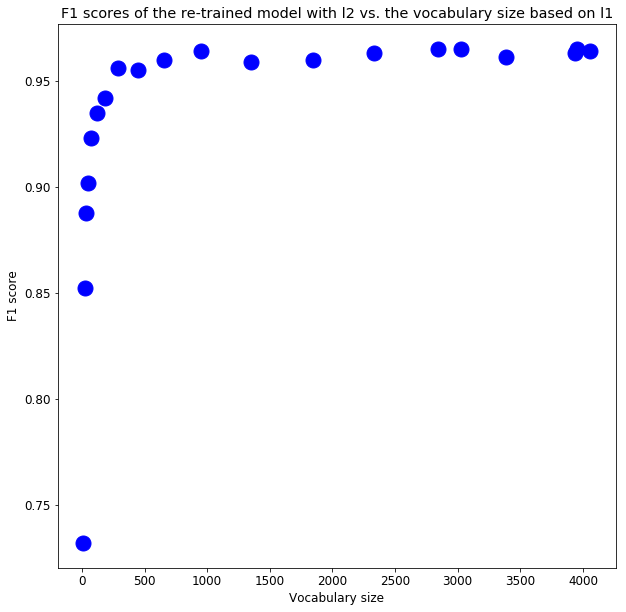

In [8]:
def yelp_review_logistic_regression_model(train_data = train_data,
                                          train_labels = train_labels,
                                          test_data = dev_data,
                                          test_labels = dev_labels,
                                          seed = 1234):
    # Keep this random seed so that this function is reproducible.
    np.random.seed(seed)
    count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
    dtm_train = count_vectorizer.fit_transform(train_data)
    # compare the number of nonzero weights from l1 and l2
    logistic_l1 = LogisticRegression(penalty="l1")
    logistic_l1.fit(dtm_train, train_labels)
    # Method 1 using np.nonzero
    print("Number of nonzero weights with l1 penalty is {:d}.".format(len(set((np.nonzero(logistic_l1.coef_))[1]))))
    logistic_l2 = LogisticRegression(penalty="l2")
    logistic_l2.fit(dtm_train, train_labels)
    print("Number of nonzero weights with l2 penalty is {:d}.".format(len(set((np.nonzero(logistic_l2.coef_))[1]))))
    
    # vary C parameters and plot the graph
    vocabsizes = []
    l1_cs = []
    f1_scores = []
    for i in np.logspace(-3, 2, num=20):
        logistic_l1 = LogisticRegression(penalty="l1", tol=0.01, C=i)
        logistic_l1.fit(dtm_train, train_labels)
        # features that have at least one non-zero weights under l1 penalty
        l1_nonzero_vocab = np.array(count_vectorizer.get_feature_names())[list(set((np.nonzero(logistic_l1.coef_))[1]))]
        vocabsizes.append(len(l1_nonzero_vocab))
        l1_cs.append(i)
        # using vocabulary based on non-zero weights from l1 penalty logistic regression results
        vectorizer_with_reduced_vocab = CountVectorizer(vocabulary=l1_nonzero_vocab)
        dtm_with_reduced_vocab = vectorizer_with_reduced_vocab.fit_transform(train_data)
        dtm_test_with_reduced_vocab = vectorizer_with_reduced_vocab.transform(test_data)
        # fit logistic regression with penalty l2
        logistic_l2_retrain = LogisticRegression(penalty="l2")
        logistic_l2_retrain.fit(dtm_with_reduced_vocab, train_labels)
        f1_scores.append(metrics.f1_score(test_labels,
                                          logistic_l2_retrain.predict(dtm_test_with_reduced_vocab),
                                          average = 'macro'))
    
    # plot the results
    plt.figure(figsize=(10,10))
    plt.plot(vocabsizes, f1_scores, 'bo', markersize=15)
    plt.title('F1 scores of the re-trained model with l2 vs. the vocabulary size based on l1')
    plt.xlabel('Vocabulary size')
    plt.ylabel('F1 score')
    plt.rcParams["font.size"] = 12
    
    print("Best F1 score with L2 regularization is {:.2f}.\nThe best F1 score is achieved by using the vocabulary size {:d} determined by L1 regularization with C parameter {:.5f}"\
          .format(np.max(f1_scores),vocabsizes[np.argmax(f1_scores)],l1_cs[np.argmax(f1_scores)]))

yelp_review_logistic_regression_model()    

In [9]:
def logistic_regression_with_NLP(train_data = train_data,
                                 train_labels = train_labels,
                                 test_data = dev_data,
                                 test_labels = dev_labels,
                                 included = ['ordered'],
                                 excluded = ['didn', 'shouldn', 'weren', 'doesn', 'couldn', 
                                       'dont', 'wasn', 'didnt', 'gotten']):
    lg_cs = []
    f1_scores = []
    for i in np.logspace(-3, 2, num=20):
        lg_cs.append(i)
        better_vect = NLP_text(remove_zero_weight_terms=True,
                       Logistic_Regression_optimal_C=i,
                       add_terms=set(included),
                       exclude_terms=set(excluded))
        dtm_train = better_vect.fit_transform(train_data)
        dtm_test = better_vect.transform(test_data)
        logistic_regression = LogisticRegression(penalty="l2")
        logistic_regression.fit(dtm_train, train_labels)
        f1_scores.append(metrics.f1_score(test_labels,
                                          logistic_regression.predict(dtm_test),
                                          average = 'macro'))
    print("Best F1 score with NLP is {:.2f}.\nThe best F1 score with L1 regularization C parameter {:.5f}."\
          .format(np.max(f1_scores), lg_cs[np.argmax(f1_scores)]))

logistic_regression_with_NLP(excluded=['food', 'restaurant', 'order', 'pizza'])

num of terms:  6593
num of nonzero terms:  0
add specified terms, num of new terms:  1
exclude specified terms, num of new terms:  1
num of terms:  6730
num of nonzero terms:  0
add specified terms, num of new terms:  1
exclude specified terms, num of new terms:  1
num of terms:  6833
num of nonzero terms:  0
add specified terms, num of new terms:  1
exclude specified terms, num of new terms:  1
num of terms:  6708
num of nonzero terms:  0
add specified terms, num of new terms:  1
exclude specified terms, num of new terms:  1
num of terms:  6631
num of nonzero terms:  1
add specified terms, num of new terms:  2
exclude specified terms, num of new terms:  2
num of terms:  6844
num of nonzero terms:  1
add specified terms, num of new terms:  2
exclude specified terms, num of new terms:  2
num of terms:  6581
num of nonzero terms:  7
add specified terms, num of new terms:  8
exclude specified terms, num of new terms:  8
num of terms:  6767
num of nonzero terms:  15
add specified terms, nu

#### Model 3: Random Forest Model

Next, we used Random Forest Classifier and analyzed the results.

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

train_dtm = better_vect.fit_transform(train_data)
dev_dtm = better_vect.transform(dev_data)
print (train_dtm.shape)

(24000, 605)


In [11]:
print("Training the random forest classifier....")

#Initialize a Random Forest Classifier with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, oob_score = True, random_state = 123456)

rf_model.fit(train_dtm, train_labels)
print("\nPredicting using the random forest classifier....")
predicted = rf_model.predict(dev_dtm)

print (classification_report(predicted, dev_labels))

print("\nTraining the random forest regressor....")

#Initialize a Random Forest Regressor with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, oob_score = True, random_state = 1, max_features="auto")

rf_model.fit(train_dtm, train_labels)
print("\nPredicting using the random forest regressor....")
predicted = rf_model.predict(dev_dtm)

print ("The AUC score:%.2f" % roc_auc_score(dev_labels,predicted))

Training the random forest classifier....

Predicting using the random forest classifier....
             precision    recall  f1-score   support

          0       0.92      0.93      0.93       504
          1       0.93      0.92      0.92       496

avg / total       0.92      0.92      0.92      1000


Training the random forest regressor....

Predicting using the random forest regressor....
The AUC score:0.96


#### Model 4: Support Vector Machine

- Support Vector Machine (SVM) is a powerful supervised learning algorithm for classification. It projects data onto a kernel space then maximize the margins between sets of points.

In [12]:
from sklearn.linear_model import SGDClassifier

start = time.time()
# hinge option gives a linear SVM
svm = SGDClassifier(loss='hinge', penalty='l2', 
                    alpha=1e-3, random_state=42, 
                    max_iter=5, tol=None)
svm.fit(train_dtm, train_labels)
predicted = svm.predict(test_dtm)
print (classification_report(predicted, test_labels))
print ('done in %d seconds.' % (time.time() - start))

             precision    recall  f1-score   support

          0       0.93      0.93      0.93      2489
          1       0.93      0.93      0.93      2510

avg / total       0.93      0.93      0.93      4999

done in 0 seconds.


#### Model 5: Neural Networks

Next, we trained Neural Networks using Multi-layer perceptron classifier and analyzed the results, after finding the best parameters.

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
dtm_train = count_vectorizer.fit_transform(train_data)
dtm_dev = count_vectorizer.transform(dev_data)
nn = MLPClassifier(random_state=1, early_stopping=True).fit(dtm_train, train_labels)

# Use gridsearchCV to find best parameter
def finding_best_neural_nets_param():
    
    clf = GridSearchCV(estimator=nn, param_grid=parameters)
    clf.fit(dtm_train, train_labels)
    return(clf)

# Activation function for hidden layers
parameters = {'activation': ['logistic', 'identity', 'tanh', 'relu']}
neuralnets = finding_best_neural_nets_param()
print("Best score:", neuralnets.best_score_)
print("Best parameters:", neuralnets.best_params_)

Best score: 0.9633333333333334
Best parameters: {'activation': 'logistic'}


In [15]:
# Training and predicting NNS with best parameters
nn = MLPClassifier(activation='logistic',
                   alpha=0.001,
                   learning_rate='constant',
                   random_state=1,
                   early_stopping=True).fit(dtm_train, train_labels)
predicted = nn.predict(dtm_dev)
print("Classifciation report with best parameters:")
print(classification_report(predicted, dev_labels))

Classifciation report with best parameters:
             precision    recall  f1-score   support

          0       0.96      0.96      0.96       513
          1       0.96      0.96      0.96       487

avg / total       0.96      0.96      0.96      1000



### Final results from five models using test data

##### NaiveBayes

In [16]:
predicted = bnb.predict(test_dtm)
print("Naive Bayes results with test data:")
print (classification_report(predicted, test_labels))

Naive Bayes results with test data:
             precision    recall  f1-score   support

          0       0.85      0.94      0.90      2251
          1       0.95      0.87      0.91      2748

avg / total       0.91      0.90      0.90      4999



##### Logistic Regression Model

In [17]:
# use the parameters with highest F1 score (0.96) from dev data
count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
dtm_train = count_vectorizer.fit_transform(train_data)
logistic_l1 = LogisticRegression(penalty="l1", tol=0.01, C=8.85867)
logistic_l1.fit(dtm_train, train_labels)
l1_nonzero_vocab = np.array(count_vectorizer.get_feature_names())[list(set((np.nonzero(logistic_l1.coef_))[1]))]
vectorizer_with_reduced_vocab = CountVectorizer(vocabulary=l1_nonzero_vocab)
dtm_with_reduced_vocab = vectorizer_with_reduced_vocab.fit_transform(train_data)
logistic_l2_retrain = LogisticRegression(penalty="l2")
logistic_l2_retrain.fit(dtm_with_reduced_vocab, train_labels)
# predict for test data
dtm_final_test = vectorizer_with_reduced_vocab.transform(test_data)
predicted = logistic_l2_retrain.predict(dtm_final_test)
print("Logistic Regression Model results with test data:")
print (classification_report(predicted, test_labels))

Logistic Regression Model results with test data:
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2451
          1       0.97      0.95      0.96      2548

avg / total       0.96      0.96      0.96      4999



##### Random Forest Model

In [21]:
print("Random Forest results with test data:")
predicted = rf_model.predict(test_dtm)

print ("The AUC score:%.2f" % roc_auc_score(test_labels, predicted))

Random Forest results with test data:
The AUC score:0.96


##### Support Vector Machine

In [22]:
print("SVM results with test data:")
predicted = svm.predict(test_dtm)
print (classification_report(predicted, test_labels))

SVM results with test data:
             precision    recall  f1-score   support

          0       0.93      0.93      0.93      2489
          1       0.93      0.93      0.93      2510

avg / total       0.93      0.93      0.93      4999



##### Neural Networks

In [25]:
print("Neural Network results with test data:")
count_vectorizer = CountVectorizer(strip_accents='ascii', stop_words='english', min_df=0.001)
dtm_train = count_vectorizer.fit_transform(train_data)
dtm_test = count_vectorizer.transform(test_data)
predicted = nn.predict(dtm_test)
print(classification_report(predicted, test_labels))

Neural Network results with test data:
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      2442
          1       0.97      0.96      0.97      2557

avg / total       0.97      0.96      0.96      4999



## Sentiment Analysis

In the following, we analyze the sentiment of the review using AFINN sentiment analysis Python package (see the following reference), which is wordlist-based approach for sentiment analysis. 

Reference: Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

We first present the results on bars followed by results for restaurants.

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


stopwords = set(STOPWORDS)
stopwords.add("place")
stopwords.add("food")
stopwords.add("restaurant")
stopwords.add("order")
stopwords.add("pizza")

def generate_wordcloud(text, spwds = stopwords):
    wordcloud = WordCloud(background_color="white", max_words=2000,
                          stopwords = spwds # set or space-separated string
                          ).generate(text)
    plt.figure(figsize=(20,20))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [2]:
from afinn import Afinn


def negative_phases_preprocessor(s):
    s = re.sub(r"don't like", "dislike", s)
    s = re.sub(r"does not like", "dislike", s)
    s = re.sub(r"didn't like", "dislike", s)
    s = re.sub(r"not good", "bad", s)
    s = re.sub(r"isn't good", "bad", s)
    s = re.sub(r"aren't good", "bad", s)
    s = re.sub(r"not great", "bad", s)
    return s

def get_sentiments(data):
    scores = np.empty(data.shape[0])
    words = np.empty(data.shape[0], dtype=object)
    afinn = Afinn()
    for i in range(data.shape[0]):
        updated_data = negative_phases_preprocessor(data[i])
        scores[i] = afinn.score(updated_data)
        words[i] = ' '.join(word for word in afinn.find_all(updated_data))
    return scores, words

### Analyzing Bars

In the following, we perform the similar analysis on yelp reviews with bars.

In [6]:
bar_train_data, bar_train_labels, bar_test_data, bar_test_labels, bar_dev_data, bar_dev_labels = load_data(fnm ='bars_data')

print ('bar train data size: ', bar_train_data.shape)
print ('bar test data size: ', bar_test_data.shape)
print ('bar dev data size: ', bar_dev_data.shape)

Total data size: 30000
bar train data size:  (24000,)
bar test data size:  (4999,)
bar dev data size:  (1000,)


In [7]:
start_time=time.time()
bars_sentiments_scores, bars_sentiments_words = get_sentiments(bar_train_data)
end_time=time.time()
print("Time for calculating bars sentiments takes ",end_time-start_time,"s.")

Time for calculating bars sentiments takes  141.8643627166748 s.


##### Word clouds for bars with postive reviews

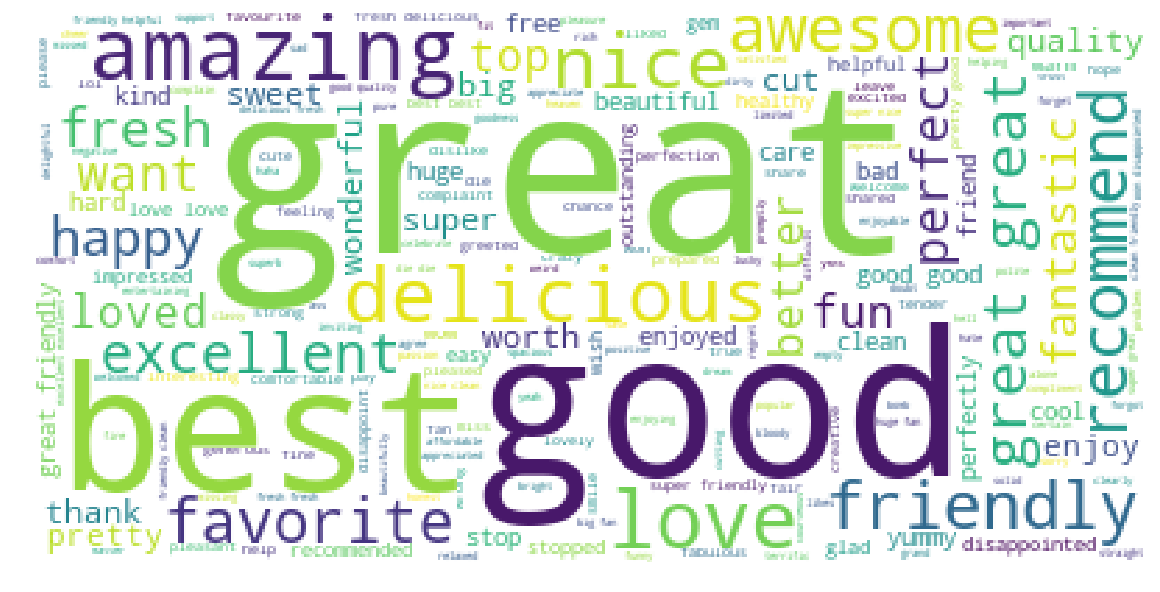

In [8]:
generate_wordcloud(" ".join(bars_sentiments_words[bar_train_labels == 1]))

##### Word cloud for bars with negative reviews

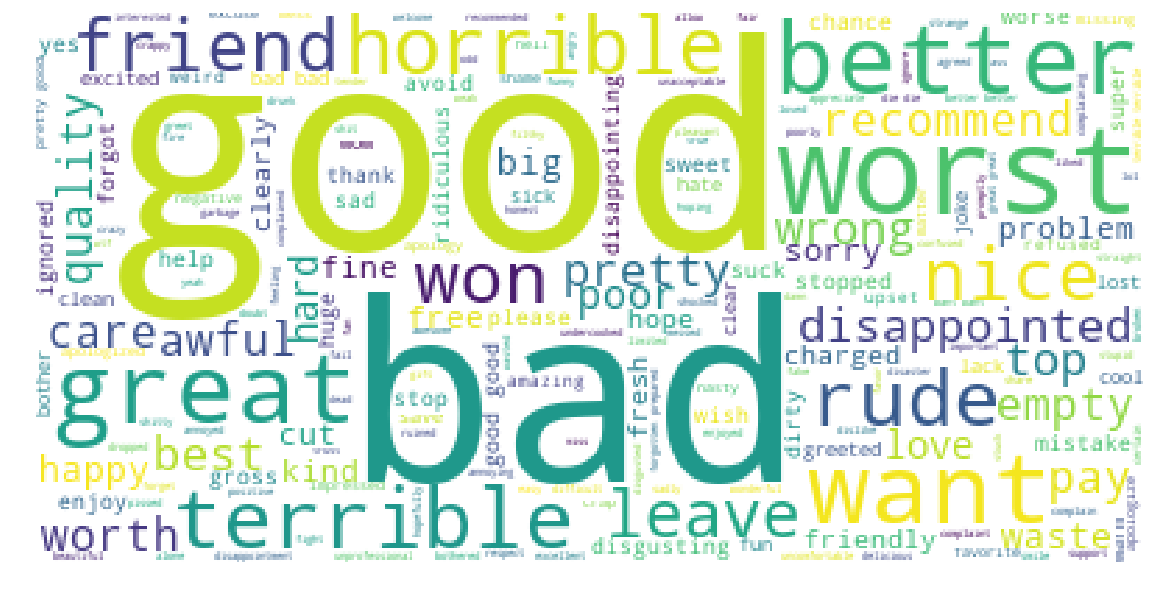

In [9]:
generate_wordcloud(" ".join(bars_sentiments_words[bar_train_labels == 0]))

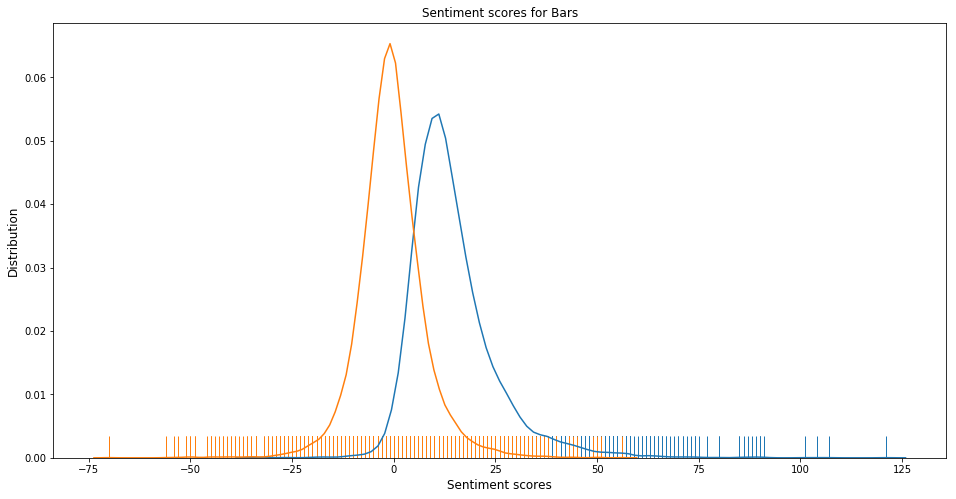

In [11]:
plt.figure(figsize=(16,8))
sns.distplot(bars_sentiments_scores[bar_train_labels == 1], hist=False, rug=True)
sns.distplot(bars_sentiments_scores[bar_train_labels == 0], hist=False, rug=True)
plt.ylabel('Distribution', fontsize=12)
plt.xlabel('Sentiment scores', fontsize=12)
plt.title("Sentiment scores for Bars")
plt.show()

In following, we try to look at the top 5 sentiment scores for negative reviewed bars.

In [12]:
dfbars = pd.DataFrame(bar_train_data)
dfbars['Y'] = bar_train_labels
dfbars['sentiment_scores'] = bars_sentiments_scores
dfbars['sentiment_words'] = bars_sentiments_words

print(dfbars.groupby('Y', as_index=False, sort=False)['sentiment_scores'].apply(lambda grp: grp.nlargest(5)))

0  4733     121.0
   1608     107.0
   10638    104.0
   8164     101.0
   11939     91.0
1  11607     56.0
   12735     51.0
   3011      50.0
   6054      49.0
   11332     45.0
Name: sentiment_scores, dtype: float64


In [13]:
for i in [11607, 12735, 3011, 6054, 11332]:
    print("#"*100)
    print("Sentiment words:\n",dfbars.loc[i].sentiment_words)
    print('-'*100)
    print("Review:\n", dfbars.loc[i].X)
    print("#"*100)

####################################################################################################
Sentiment words:
 friendly praise celebrate pretty disappointed quality wish good ensure blame nice bad good love fan better like better disappointed chaotic good share good enjoy liking prepared want nice weird like popular nice good great great satisfied
----------------------------------------------------------------------------------------------------
Review:
 Everything about PORT has gone downhill. Aside from the view itself from the patio and the friendly servers, there isn't much to praise about this restaurant.

Last Saturday, my boyfriend reserved a table of 10 for us to celebrate my 28th birthday and we were all pretty disappointed with the overall service and quality of food and wish we had chosen somewhere else to eat. 

Let's start with the good. Our server was fairly attentive and came around to check on us a few times and ensure we had our drinks etc. I wouldn't blame he

### Analyzing Restaurants

In the following, we perform the similar analysis with reviews for the restaurants.


In [19]:
start_time=time.time()
train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_data(fnm = "data_restaurants_reviews_30_to_200_stars_1_5")
train_data_sentiments_scores, train_data_sentiments_words = get_sentiments(train_data)
end_time=time.time()
print("Time for calculating sentiments takes ",end_time-start_time,"s.")

Time for calculating sentiments takes  132.07742428779602 s.


Text(0.5,1,'Sentiment score distribution from postive reviews')

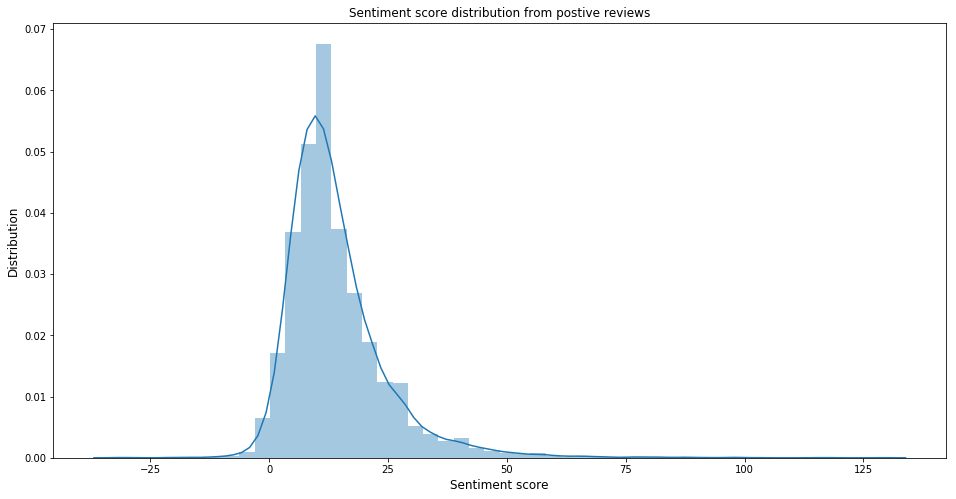

In [29]:
import seaborn as sns
plt.figure(figsize=(16,8))
sns.distplot(train_data_sentiments_scores[train_labels == 1])
plt.ylabel('Distribution', fontsize=12)
plt.xlabel('Sentiment score', fontsize=12)
plt.title("Sentiment score distribution from postive reviews")

Text(0.5,1,'Sentiment score distribution from negative reviews')

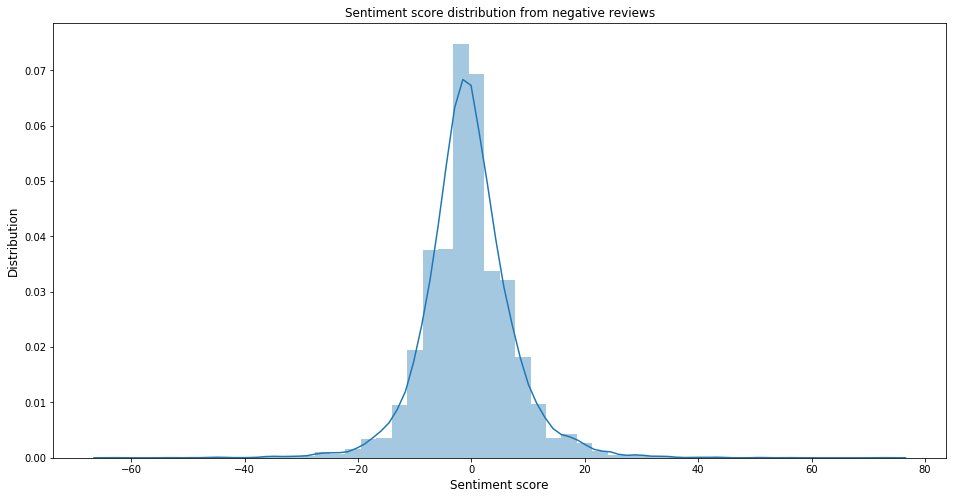

In [30]:
plt.figure(figsize=(16,8))
sns.distplot(train_data_sentiments_scores[train_labels == 0])
plt.ylabel('Distribution', fontsize=12)
plt.xlabel('Sentiment score', fontsize=12)
plt.title("Sentiment score distribution from negative reviews")

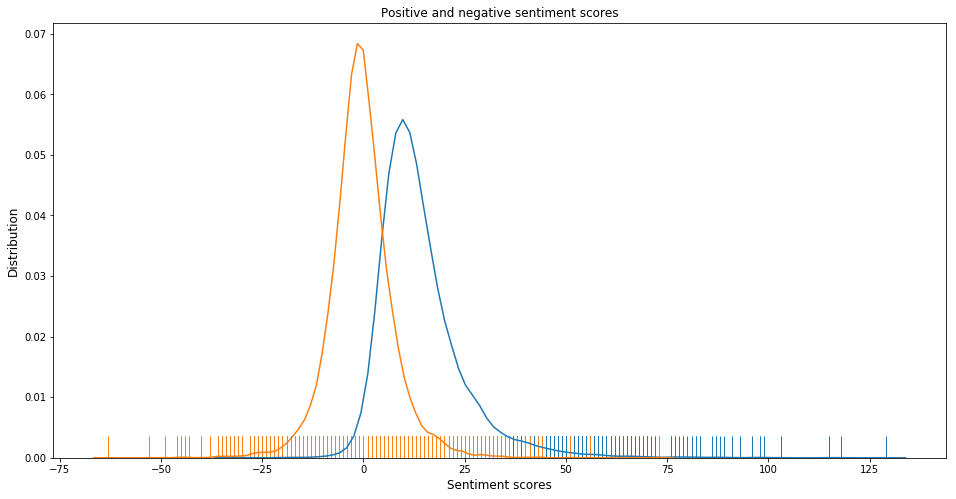

In [33]:
plt.figure(figsize=(16,8))
sns.distplot(train_data_sentiments_scores[train_labels == 1], hist=False, rug=True)
sns.distplot(train_data_sentiments_scores[train_labels == 0], hist=False, rug=True)
plt.ylabel('Distribution', fontsize=12)
plt.xlabel('Sentiment scores', fontsize=12)
plt.title("Positive and negative sentiment scores")
plt.show()

##### Sentiment of word cloud for positive restaurant reviews

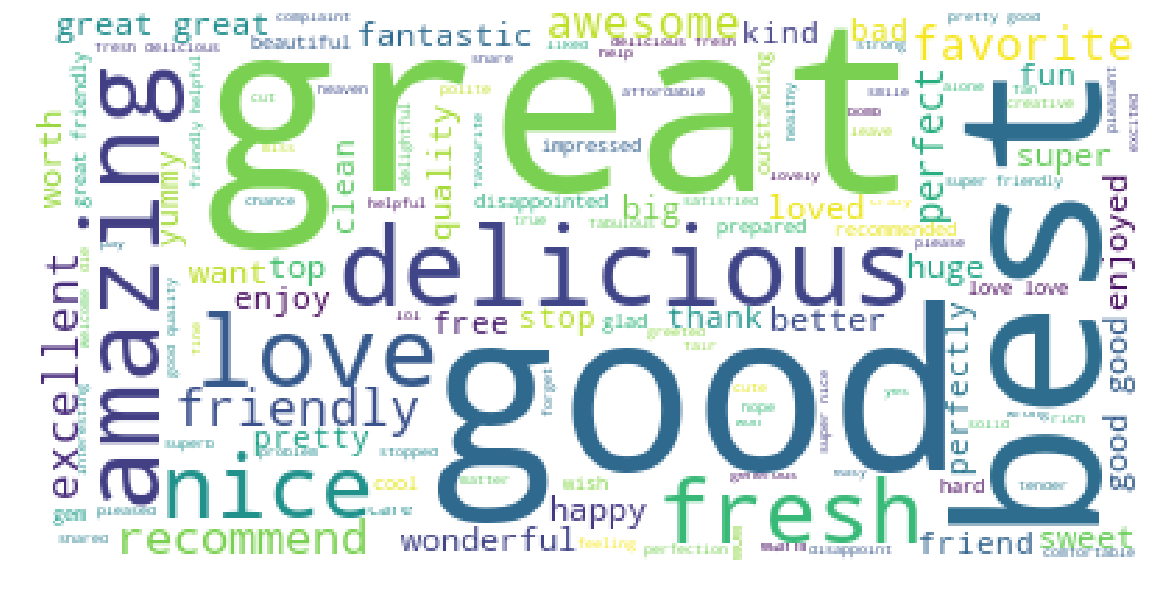

In [25]:
generate_wordcloud(" ".join(train_data_sentiments_words[train_labels == 1]))

##### Sentiment of word cloud for negative restaurant reviews

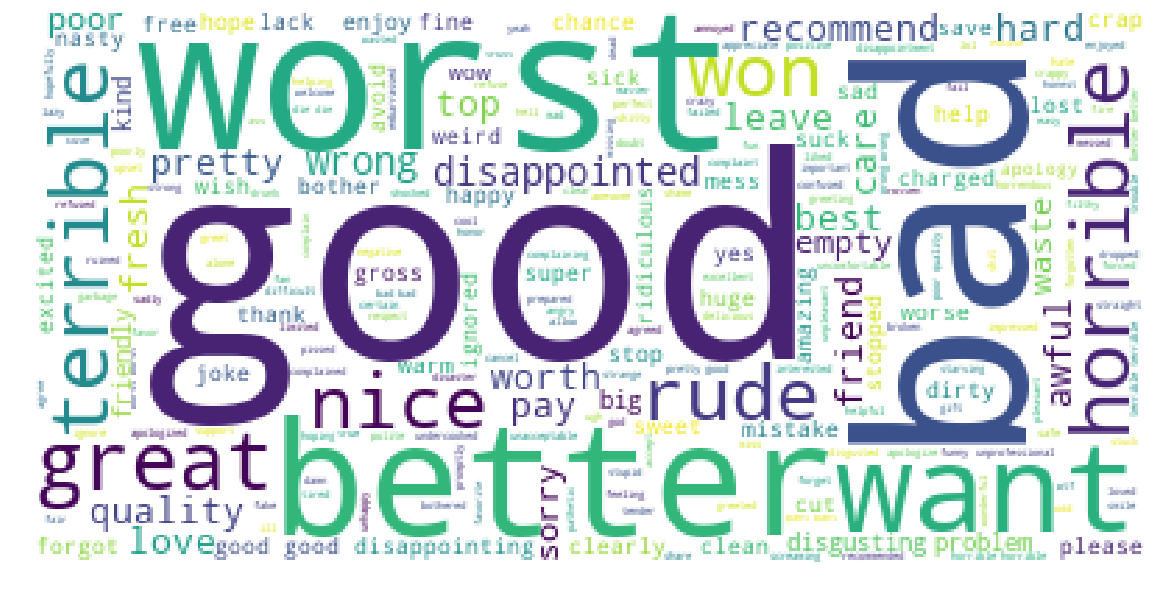

In [26]:
generate_wordcloud(" ".join(train_data_sentiments_words[train_labels == 0]))

## Conclusions

In this project, we focused on two main goals. The first goal is to predict reviewers' attitudes. We compared several supervised machine learning algorithms including Naive Bayes, Logistic Regression, Random Forest, Neural Networks, Support Vector Machine.  Both Logistic Regression and Neural Network classifiers yielded 0.96 F1-score, while both Support Vector Machine and Random Forest give the accuracy of 0.93.  Naive Bayes classifier has the lowest accuracy 0.90.

We also performed sentiment analysis for both bars and restaurants. It works well for good restaurants/bars, but not so well for bad restaurants/bars. We performed the error analysis and we believe that additional context analysis capabilities are needed to improve the sentiment analysis for bad restaurants/bars.


### Appendix: Exploratory Data Analysis

In this section, we present the Exploratory Data Analysis (EDA) for the Yelp review data set. The goals of EDA are: (1) understand the dataset characteristics; (2) identify the relationship between Yelp ratings and business quality such that meaningful and practical supervised machine learning data set is constructed.

#### Load the raw data set into Pandas data frame

In [3]:
start_time=time.time()
business=pd.read_csv("yelp_dataset/yelp_business.csv")
business_attributes=pd.read_csv("yelp_dataset/yelp_business_attributes.csv")
business_hours=pd.read_csv("yelp_dataset/yelp_business_hours.csv")
check_in=pd.read_csv("yelp_dataset/yelp_checkin.csv")
reviews=pd.read_csv("yelp_dataset/yelp_review.csv", nrows=17746270)
tip=pd.read_csv("yelp_dataset/yelp_tip.csv")
user=pd.read_csv("yelp_dataset/yelp_user.csv")
end_time=time.time()
print("Reading all cvs files took ",end_time-start_time,"s")

Reading all cvs files took  75.54727172851562 s


In [4]:
print("Number of reviews {:d}".format(reviews.shape[0]))
reviews.head(5)

Number of reviews 5261668


,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [5]:
print("Number of business {:d}.".format(business.shape[0]))
business.head(5)

Number of business 174567.


,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


#### Basic data characteristics

Text(0.5,0,'Star Ratings ')

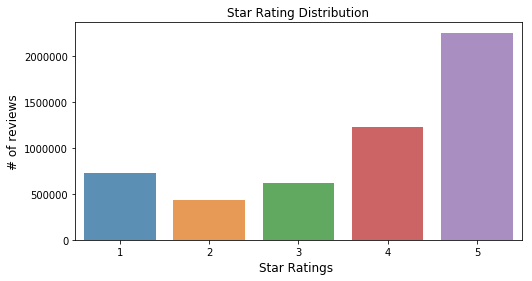

In [6]:
# visualize the data characteristics
import seaborn as sns 
review_stars = reviews['stars'].value_counts().sort_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(review_stars.index, review_stars.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

The Yelp review star ratings are clearly not uniformly distributed. The reviews with 5 stars dominates among all reviews (more than 2 millions 5-star reviews).

In the following, let us look at the distribution of business categories.

There are  59106  categories of Businesses in Yelp.


Text(0.5,0,'Category')

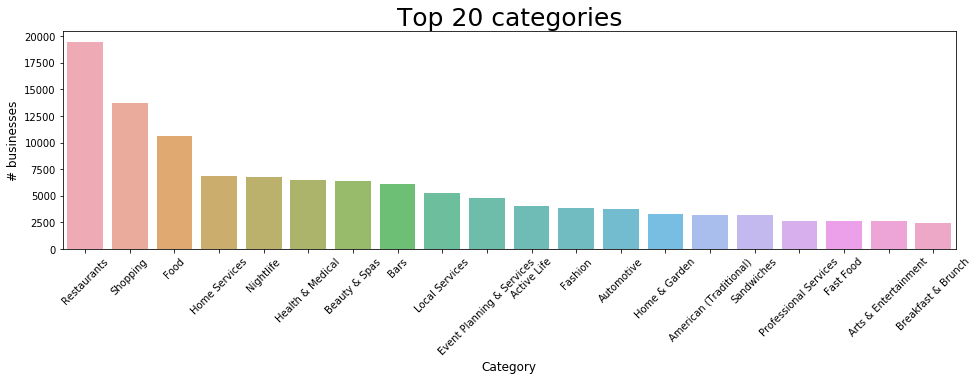

In [11]:
categories = pd.DataFrame(' '.join(business['categories']).split(';'),columns=['category'])\
            .category.value_counts().sort_values(ascending=False)
print("There are ",len(categories)," categories of Businesses in Yelp.")

plt.figure(figsize=(16,4))
ax = sns.barplot(categories[0:20].index, categories[0:20].values, alpha=0.8)
plt.title("Top 20 categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

The above figure shows that restaurant type is the top one business category. Clearly, it is hard to compare business from different categories. We can focus on restaurants since it is the most common business type on Yelp. In the following, we will investigate the number of reviews distritution for each restaurant.

count    54630.000000
mean        58.963372
std        150.746018
min          3.000000
25%          7.000000
50%         18.000000
75%         54.000000
max       7361.000000
Name: review_count, dtype: float64


Text(0.5,0,'Review count')

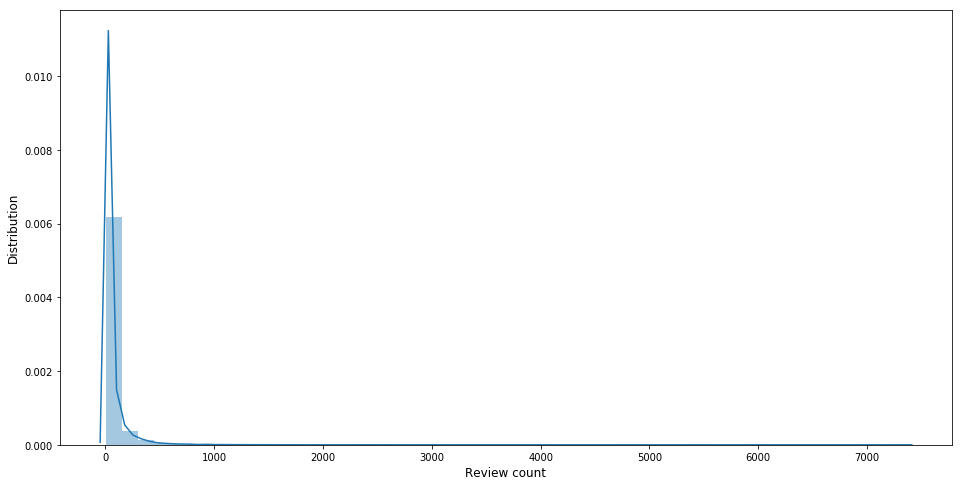

In [17]:
restaurant_review_cnt = business.loc[(business['categories'].str.lower().str.contains('restaurant'))]['review_count']
print(restaurant_review_cnt.describe())
plt.figure(figsize=(16,8))
sns.distplot(restaurant_review_cnt)
plt.ylabel('Distribution', fontsize=12)
plt.xlabel('Review count', fontsize=12)

The distribution and statistics show that 50% restaurants received $\le$ 18 reviews. The distribution is right skewed. Restaurants with small number of reviews are more likely biased. Based on the above distribution, we zoom in restaurants with 30 - 200 reviews. 

Text(0.5,0,'Review count')

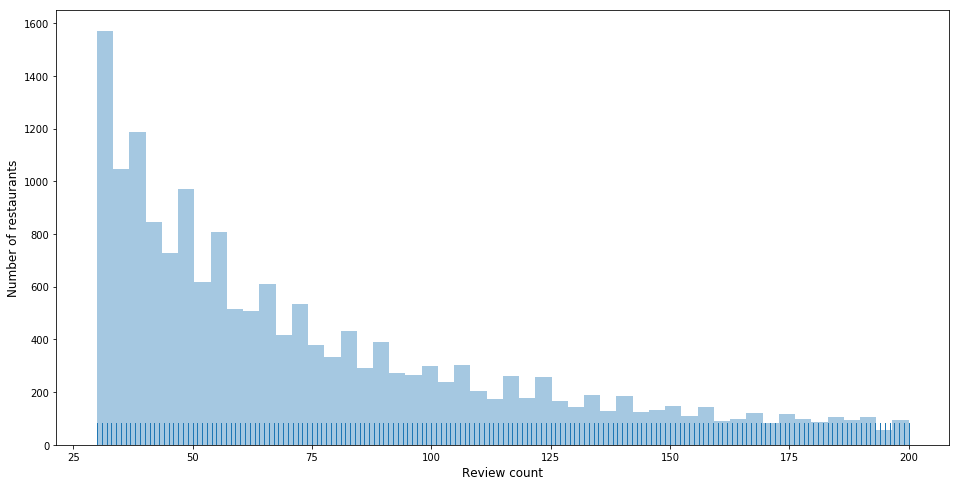

In [25]:
restauntants_with_30_to_200_reviews = business.loc[(business['review_count'].isin(range(30,201))) & (business['categories'].str.lower().str.contains('restaurant'))]

plt.figure(figsize=(16,8))
sns.distplot(restauntants_with_30_to_200_reviews['review_count'], kde=False, rug=True, bins=50)
plt.ylabel('Number of restaurants', fontsize=12)
plt.xlabel('Review count', fontsize=12)

In [26]:
reviews_merged_with_restauntants_with_30_to_200_reviews = pd.merge(reviews, restauntants_with_30_to_200_reviews, how = 'right', on = 'business_id')
print('Total number of reviews for restaunts that have 30 to 200 reviews:', reviews_merged_with_restauntants_with_30_to_200_reviews.shape[0])

Total number of reviews for restaunts that have 30 to 200 reviews: 1322151


Thus, we have more than 1.3 million reviews that were written for restaurants. Each of these restaurants has number of reviews between 30 to 200. In the following, we plot the number of reviews for each star ratings.

Text(0.5,0,'Star ratings ')

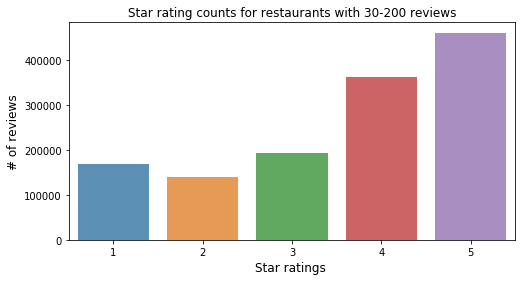

In [28]:
x = reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'].value_counts().sort_index()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star rating counts for restaurants with 30-200 reviews")
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Star ratings ', fontsize=12)

In [30]:
print("Number of reviews with 1 star rating: ", reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] <2].shape[0])
print("Number of reviews with 5 star rating: ", reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] >4].shape[0])

Number of reviews with 1 star rating:  168524
Number of reviews with 5 star rating:  459991


This distribution is very similar to ratings distribution we plotted earlier for the full data set. In another words, after we filtered the data set with business category restaurants and number of reviews for each restaurant, the star rating distribution remains the same. In the following, we randomly select 15000 from reviews with rating 1 (less than 10% of all reviews with 1 stars) and 15000 reviews with rating 5 (about 3% of total 5 star reviews). We use this random sampled data to explore the characteritics of the text and business sentiments.

In [31]:
np.random.seed(0)
negative_samples = reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] <2].sample(15000)
positive_samples = reviews_merged_with_restauntants_with_30_to_200_reviews.loc[reviews_merged_with_restauntants_with_30_to_200_reviews['stars_x'] >4].sample(15000)
selected_data = pd.concat([negative_samples, positive_samples])
print(selected_data.shape)

(30000, 21)


#### Word cloud

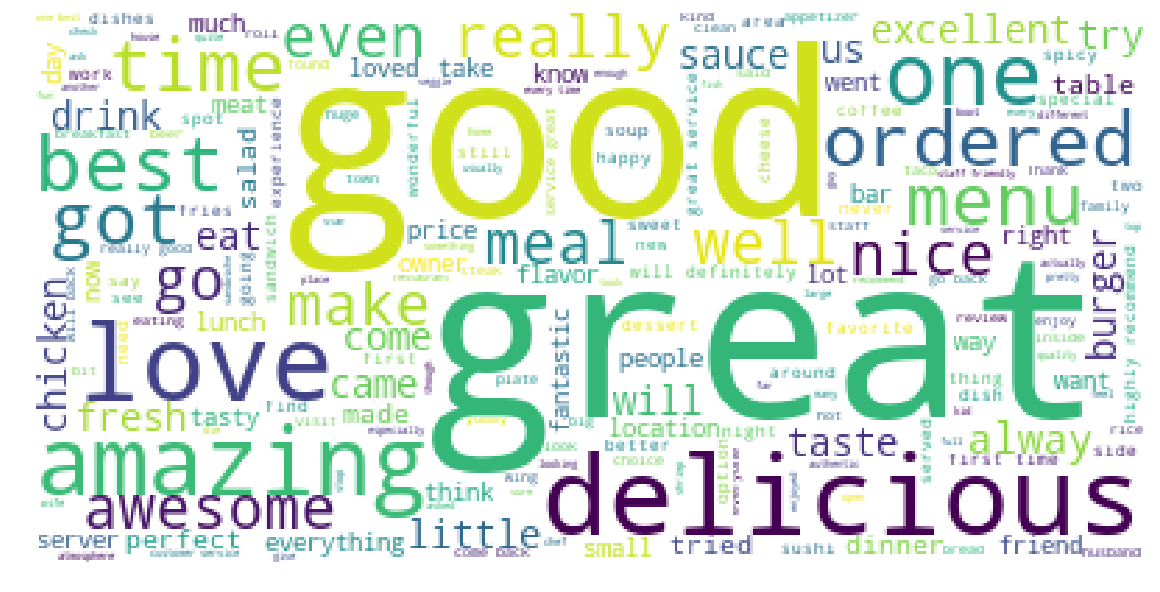

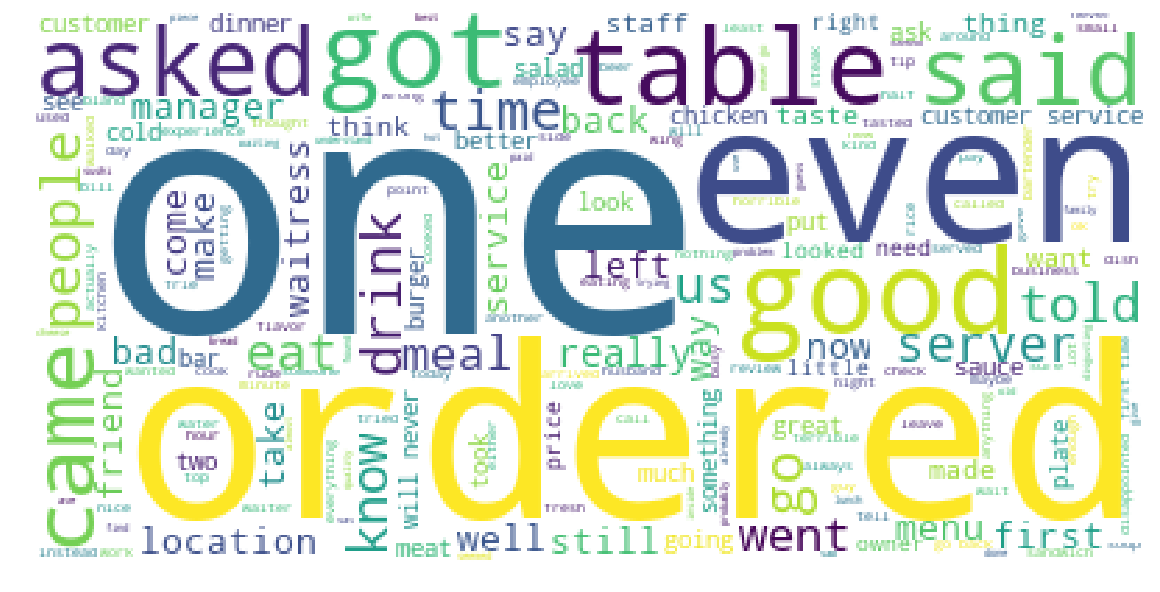

In [11]:
positive  = " ".join(train_data[train_labels == 1])
generate_wordcloud(positive)

negative  = " ".join(train_data[train_labels == 0])
generate_wordcloud(negative)